# EDA Gaia Parallaxes

In [1]:
# Basic Packages
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
import gc

pd.options.display.max_rows = 200

# plot settings
#plt.rc('font', family='serif') 
#plt.rc('font', serif='Times New Roman') 
plt.rcParams.update({'font.size': 16})
#plt.rcParams['mathtext.fontset'] = 'stix'

In [2]:
# PySpark packages
from pyspark import SparkContext   
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession

sc = spark.sparkContext
sqlsc = SQLContext(sc)
sc.setCheckpointDir("hdfs://spark00:54310/tmp/checkpoints")

import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark import Row
from pyspark.sql.window import Window as W

/usr/local/spark/python/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [3]:
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

## Read all sky data 

In [4]:
import pyarrow as pa
import pyarrow.parquet as pq

In [5]:
filepath = \
"hdfs://spark00:54310/common/data/catalog/external-catalogs/parquet/gaia-dr3/reduced/rawstar.parquet.snappy"

#### Read `rawstardf`

In [6]:
%%time
rawstardf = spark.read.parquet(filepath)

CPU times: user 0 ns, sys: 1.25 ms, total: 1.25 ms
Wall time: 2.1 s


In [7]:
rawstardf.printSchema()
#print(rawdf.columns)

root
 |-- source_id: long (nullable = true)
 |-- ra: double (nullable = true)
 |-- dec: double (nullable = true)
 |-- parallax: double (nullable = true)
 |-- pm: float (nullable = true)
 |-- pmra: double (nullable = true)
 |-- pmdec: double (nullable = true)
 |-- astrometric_excess_noise: float (nullable = true)
 |-- ruwe: float (nullable = true)
 |-- classprob_dsc_combmod_quasar: float (nullable = true)
 |-- classprob_dsc_combmod_galaxy: float (nullable = true)
 |-- classprob_dsc_combmod_star: float (nullable = true)
 |-- ra_error: float (nullable = true)
 |-- dec_error: float (nullable = true)
 |-- parallax_error: float (nullable = true)
 |-- parallax_over_error: float (nullable = true)
 |-- pmra_error: float (nullable = true)
 |-- pmdec_error: float (nullable = true)
 |-- l: double (nullable = true)
 |-- b: double (nullable = true)
 |-- bp_rp: float (nullable = true)
 |-- bp_g: float (nullable = true)
 |-- g_rp: float (nullable = true)
 |-- ipx512nested: integer (nullable = true)
 |

In [8]:
# Basic Packages for HealPix
import healpy as hp
NSIDE = 512
NPIX = hp.nside2npix(NSIDE)
full_index = pd.RangeIndex(start=0, stop=NPIX)
print(NPIX)

3145728


## Analyzing Parallax Values

In [9]:
%%time
n_negative_parallax = rawstardf.select('parallax').filter(F.col('parallax') < 0.0).count()
print(n_negative_parallax)

298359331
CPU times: user 1.61 ms, sys: 1.78 ms, total: 3.39 ms
Wall time: 11.7 s


> About these negative parallaxes: <br> https://github.com/agabrown/astrometry-inference-tutorials/blob/master/luminosity-calibration/DemoNegativeParallax.ipynb

In [10]:
negativestarcountdf = \
rawstardf.filter(F.col('parallax') < 0.0).groupBy('gal_ipx512nested').agg(F.count("*").alias("count"))

In [11]:
%%time
tmppdf = negativestarcountdf.orderBy('gal_ipx512nested'). \
toPandas().set_index('gal_ipx512nested').reindex(full_index, fill_value=0)

CPU times: user 90.4 ms, sys: 49.9 ms, total: 140 ms
Wall time: 11.4 s


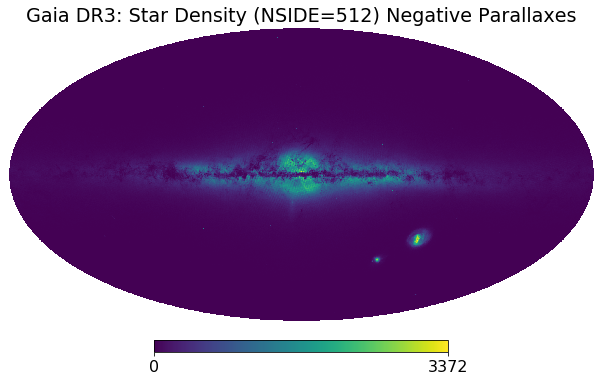

In [12]:
hp.mollview(tmppdf['count'].values,nest=True, \
            title='Gaia DR3: Star Density (NSIDE=512) Negative Parallaxes',xsize=2000)

#### Finding a valid parallax range

In [13]:
%%time
n_overone_parallax = rawstardf.select('parallax').filter(F.col('parallax') > 1000.0).count()
print(n_overone_parallax)

0
CPU times: user 1.88 ms, sys: 0 ns, total: 1.88 ms
Wall time: 494 ms


In [14]:
%%time
n_infinitesimal_parallax = rawstardf.select('parallax').filter(F.col('parallax') < 1.0-8).count()
print(n_overone_parallax)

0
CPU times: user 3.95 ms, sys: 879 µs, total: 4.83 ms
Wall time: 6.62 s


> Overall, only negative parallaxes are problematic. 

#### Remove extreme parallax

In [15]:
%%time
stardf = rawstardf.filter((F.col('parallax') < 1000.0) & (F.col('parallax') > 1.0e-8))

CPU times: user 754 µs, sys: 0 ns, total: 754 µs
Wall time: 3.98 ms


> What is the fiducial limit of parallax? 1000 ~ 1e-8

In [16]:
%%time
stardf.select('parallax').count()

CPU times: user 1.71 ms, sys: 19 µs, total: 1.73 ms
Wall time: 9.03 s


1006620092

In [17]:
#stardf.select('parallax').show(3)

#### Apply a short form of `lambda-udf `

In [18]:
import math

In [19]:
math.log10(10.0)

1.0

In [20]:
%time
getparsec = F.udf(lambda x: math.log10(1000.0/x), T.FloatType())
stardf = stardf.withColumn('logparsecs',getparsec(F.col('parallax')))

CPU times: user 1e+03 ns, sys: 1 µs, total: 2 µs
Wall time: 2.62 µs


> `np.log10()` should work. But the issue is its output type: `numpy.float` is not for pyspark's float. Hence, you have to write the code like this `float(np.log10(1000.0/x))` for explicitly converting the type.  

In [21]:
%%time
stardf.select('parallax','logparsecs').show(3)

+-------------------+----------+
|           parallax|logparsecs|
+-------------------+----------+
| 0.9115141694103105| 3.0402365|
|0.07759278213395875| 4.1101785|
|0.40935135899453134| 3.3879037|
+-------------------+----------+
only showing top 3 rows

CPU times: user 1.1 ms, sys: 970 µs, total: 2.07 ms
Wall time: 478 ms


In [22]:
math.log10(1.0/0.3543305595550248)

0.45059138993670944

In [23]:
%%time
bins, counts = stardf.select('logparsecs').rdd.flatMap(lambda x: x).histogram(500)

CPU times: user 148 ms, sys: 93.1 ms, total: 241 ms
Wall time: 1min 21s


In [24]:
len(bins)

501

In [25]:
len(counts)

500

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


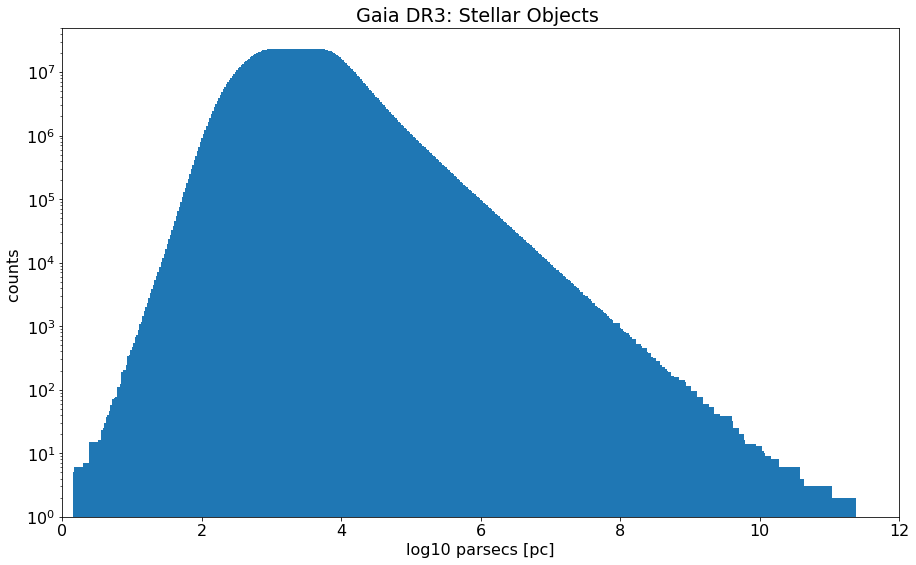

In [26]:
#bins, counts

#plot settings
plt.rc('font', family='serif') 
plt.rc('font', serif='Times New Roman') 
plt.rcParams.update({'font.size': 16})
plt.rcParams['mathtext.fontset'] = 'stix'


fig = plt.figure(figsize=(15,9))

plt.axis([0,12,1,5.0e7])
#plt.axes().set_aspect('equal', 'datalim')
plt.title(r'Gaia DR3: Stellar Objects ')
plt.xlabel(r'log10 parsecs [pc]')
plt.ylabel(r'counts ')
plt.yscale('log')
#plt.scatter(slicedf.px.values,slicedf.py.values,marker=".",s=1.0,color='grey')
plt.bar(bins[1:],counts)

plt.show()


## 3D Coordinates on Galactic Plane

* Explore reliable parallaxes
* Assign `gal_x`, `gal_y`, `gal_z`

#### Explore reliable parallaxes

In [27]:
stardf.limit(3).toPandas().transpose()

,0,1,2
source_id,6.651861e+18,6.651861e+18,6.651861e+18
ra,2.715266e+02,2.715149e+02,2.715235e+02
dec,-5.680934e+01,-5.682401e+01,-5.681182e+01
parallax,5.756131e-01,8.789403e-01,2.683147e-02
pm,7.346515e+00,1.073212e+01,1.031875e+01
pmra,-2.200970e+00,-1.460846e+00,-3.632124e+00
pmdec,-7.009067e+00,-1.063223e+01,-9.658382e+00
astrometric_excess_noise,0.000000e+00,4.741412e-01,2.253606e-01
ruwe,1.007008e+00,1.133978e+00,1.036321e+00
classprob_dsc_combmod_quasar,1.031956e-13,2.071846e-13,1.021453e-13


In [28]:
%%time
stardf.select('l','b','parallax_over_error').describe().show()

+-------+--------------------+-------------------+-------------------+
|summary|                   l|                  b|parallax_over_error|
+-------+--------------------+-------------------+-------------------+
|  count|          1006620092|         1006620092|         1006620092|
|   mean|   185.1632444702879|-1.0515419923433134|  5.175748646187314|
| stddev|  129.07262037502596|  16.68413335138127|  19.68680339755938|
|    min|1.060633506124641...| -89.99366530605397|       1.3306138E-8|
|    max|   359.9999999850258|  89.98796453163729|          15400.477|
+-------+--------------------+-------------------+-------------------+

CPU times: user 4.14 ms, sys: 88 µs, total: 4.22 ms
Wall time: 30.6 s


> What? `gal_l` is from `-60` to `+300` ?!??

In [29]:
paral_bins = np.arange(0,100,0.2).tolist()

In [30]:
%%time
bins, counts = stardf.select('parallax_over_error').rdd.flatMap(lambda x: x).histogram(paral_bins)

CPU times: user 144 ms, sys: 49.5 ms, total: 194 ms
Wall time: 25.2 s


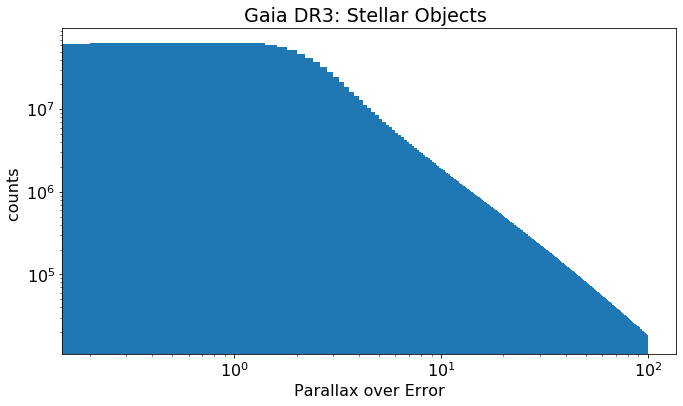

In [31]:
fig = plt.figure(figsize=(11,6))
#plt.axis([0,12,1,5.0e7])
plt.title(r'Gaia DR3: Stellar Objects ')
plt.xlabel(r'Parallax over Error')
plt.ylabel(r'counts ')
plt.yscale('log')
plt.xscale('log')
plt.bar(bins[1:],counts)
plt.show()

#### Assigning 3D galactic coordinates 

In [32]:
def get_galactic3d(gall, galb, logparsec):
    lon, lat = np.radians(gall), np.radians(galb)
    rdist = np.power(10.0,logparsec)
    
    gal_z = rdist*np.sin(lat)
    gal_x = rdist*np.cos(lat)*np.cos(lon)
    gal_y = rdist*np.cos(lat)*np.sin(lon)
        
    return [float(gal_x), float(gal_y), float(gal_z)]

In [33]:
gal3dudf = F.udf(get_galactic3d, T.ArrayType(T.FloatType()))

In [34]:
%%time
stardf = stardf.withColumn('tmp_gal_3d',gal3dudf(F.col('l'),F.col('b'),F.col('logparsecs')))
stardf = stardf.withColumn('gal_x',F.col('tmp_gal_3d').getItem(0).cast("float"))
stardf = stardf.withColumn('gal_y',F.col('tmp_gal_3d').getItem(1).cast("float"))
stardf = stardf.withColumn('gal_z',F.col('tmp_gal_3d').getItem(2).cast("float"))
stardf = stardf.drop(F.col('tmp_gal_3d'))

CPU times: user 2.5 ms, sys: 1.35 ms, total: 3.85 ms
Wall time: 39 ms


#### Random Subsampling 

In [35]:
%%time
testdf = stardf.select('gal_x','gal_y','gal_z','logparsecs','parallax_over_error','bp_g','g_rp','bp_rp') \
.sample(fraction=1e-4, seed=1).toPandas()

CPU times: user 127 ms, sys: 78 ms, total: 205 ms
Wall time: 1min 42s


In [36]:
testdf.describe()

,gal_x,gal_y,gal_z,logparsecs,parallax_over_error,bp_g,g_rp,bp_rp
count,1.007040e+05,1.007040e+05,1.007040e+05,100704.000000,100704.000000,99268.000000,99368.000000,99243.000000
mean,6.018755e+03,-2.088444e+03,-1.553998e+02,3.399652,5.197892,0.750382,0.877044,1.627089
std,3.912058e+05,4.225193e+05,1.110254e+05,0.477280,18.836531,0.410930,0.283286,0.593049
min,-2.440999e+07,-1.078311e+08,-1.205540e+07,1.360762,0.000009,-4.122058,-0.861132,-1.803410
25%,8.043824e+01,-1.287663e+03,-3.605481e+02,3.095851,0.815772,0.486705,0.674640,1.198963
50%,9.925871e+02,-7.517147e+01,-4.330942e+01,3.358778,1.707995,0.682985,0.845406,1.538312
75%,2.430229e+03,9.886430e+02,2.481608e+02,3.639368,3.503841,0.954619,1.047671,1.965374
max,9.221460e+07,2.986201e+07,3.110306e+07,8.162126,1335.689331,5.232229,4.177073,7.498398


In [37]:
xx = 0.08*np.arange(100) - 3.0

In [38]:
yy = xx + 0.3

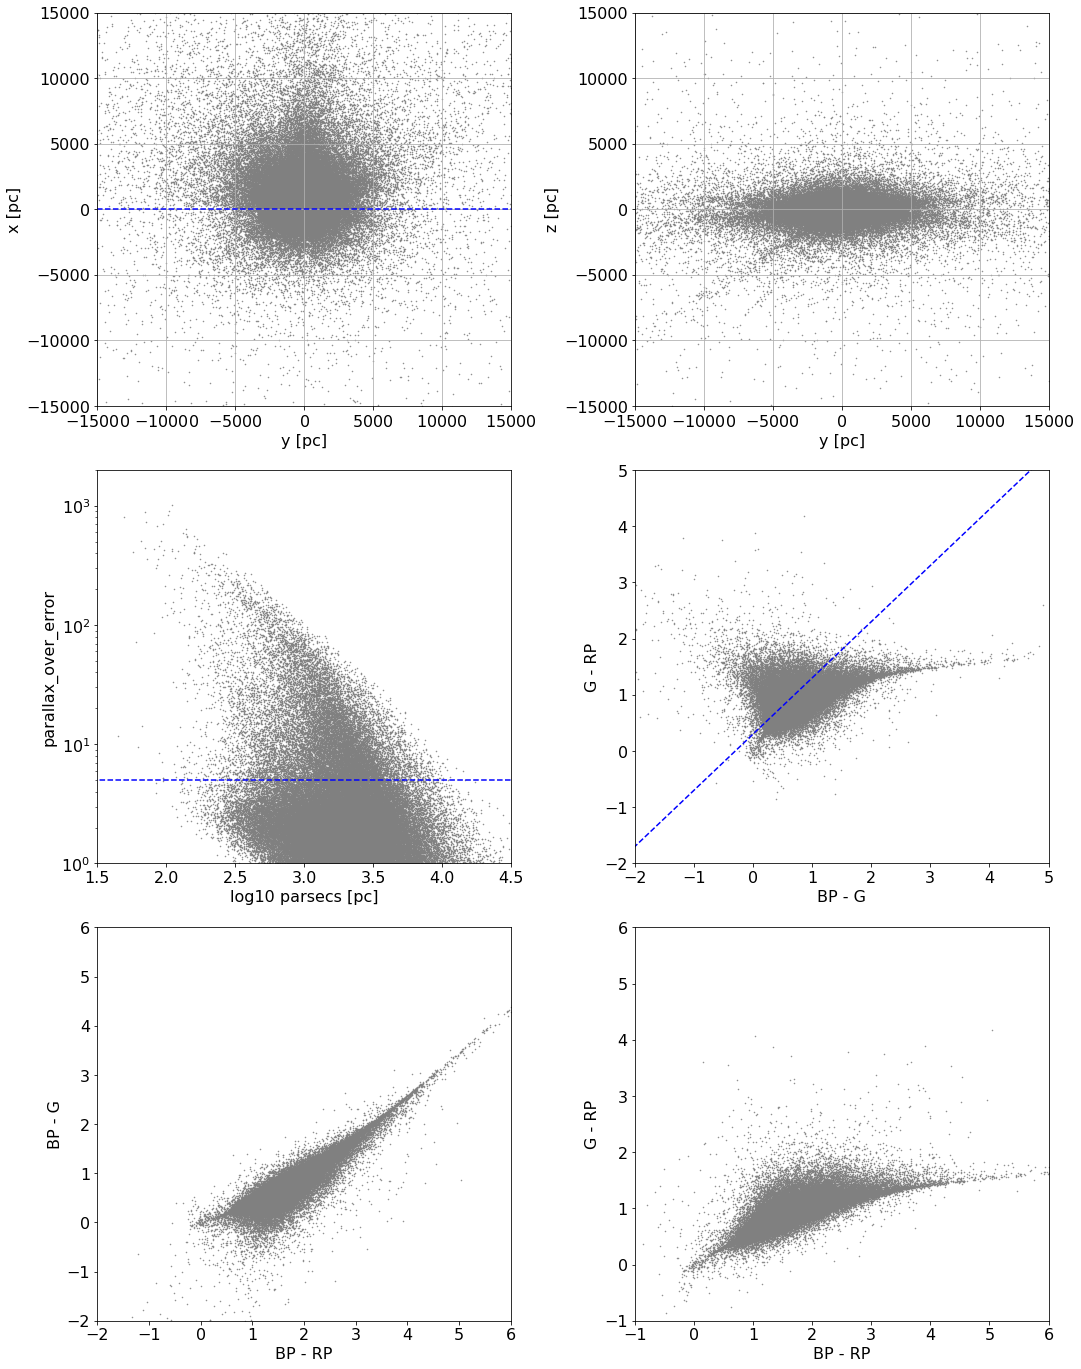

In [45]:
fig = plt.figure(figsize=(15,19))

# plot settings
#plt.rc('font', family='serif') 
#plt.rc('font', serif='Times New Roman') 
plt.rcParams.update({'font.size': 16})
#plt.rcParams['mathtext.fontset'] = 'stix'

plt.subplot(321)
plt.axis([-15000,15000,-15000,15000])
#plt.axes().set_aspect('equal')
#plt.axes().set_aspect('equal', 'datalim')
#plt.title(r'Gaia Galactic 3D Coordinates (|z| < 5 kpc)')
plt.xlabel(r'y [pc]')
plt.ylabel(r'x [pc]')
plt.scatter(testdf.gal_y.values,testdf.gal_x.values,marker=".",s=1.0,color='grey')
plt.grid()
plt.ticklabel_format(axis='x',style='sci',useMathText=True)
plt.plot([-15000,15000],[0,0],linestyle='--',color='b')

plt.subplot(322)
plt.axis([-15000,15000,-15000,15000])
#plt.axes().set_aspect('equal')
#plt.axes().set_aspect('equal', 'datalim')
#plt.title(r'Gaia Galactic 3D Coordinates (|z| < 5 kpc)')
plt.xlabel(r'y [pc]')
plt.ylabel(r'z [pc]')
plt.scatter(testdf.gal_y.values,testdf.gal_z.values,marker=".",s=1.0,color='grey')
plt.grid()
plt.ticklabel_format(axis='x',style='sci',useMathText=True)

plt.subplot(323)
plt.axis([1.5,4.5,1,2000])
#plt.axes().set_aspect('equal', 'datalim')
#plt.title(r'Gaia Galactic 3D Coordinates (|z| < 5 kpc)')
plt.xlabel(r'log10 parsecs [pc]')
plt.ylabel(r'parallax_over_error')
plt.scatter(testdf.logparsecs.values,testdf.parallax_over_error.values,marker=".",s=1.0,color='grey')
plt.yscale('log')
plt.plot([1,20000],[5,5],linestyle='--',color='b')
#plt.grid()


plt.subplot(324)
plt.axis([-2,5,-2,5])
#plt.axes().set_aspect('equal', 'datalim')
#plt.title(r'Gaia Galactic 3D Coordinates (|z| < 5 kpc)')
plt.xlabel(r'BP - G')
plt.ylabel(r'G - RP')
plt.scatter(testdf.bp_g.values,testdf.g_rp.values,marker=".",s=1.0,color='grey')
#plt.yscale('log')
plt.plot(xx,yy,linestyle='--',color='b')

plt.subplot(325)
plt.axis([-2,6,-2,6])
#plt.axis([1.5,4.5,1,2000])
#plt.axes().set_aspect('equal', 'datalim')
#plt.title(r'Gaia Galactic 3D Coordinates (|z| < 5 kpc)')
plt.xlabel(r'BP - RP')
plt.ylabel(r'BP - G')
plt.scatter(testdf.bp_rp.values,testdf.bp_g.values,marker=".",s=1.0,color='grey')
#plt.yscale('log')
#plt.plot([1,20000],[5,5],linestyle='--',color='grey')

plt.subplot(326)
plt.axis([-1,6,-1,6])
#plt.axis([1.5,4.5,1,2000])
#plt.axes().set_aspect('equal', 'datalim')
#plt.title(r'Gaia Galactic 3D Coordinates (|z| < 5 kpc)')
plt.xlabel(r'BP - RP')
plt.ylabel(r'G - RP')
plt.scatter(testdf.bp_rp.values,testdf.g_rp.values,marker=".",s=1.0,color='grey')
#plt.yscale('log')
#plt.plot([1,20000],[5,5],linestyle='--',color='grey')



plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
fig.savefig("gaia-stats.pdf")
fig.savefig("gaia-stats.png")
plt.show()

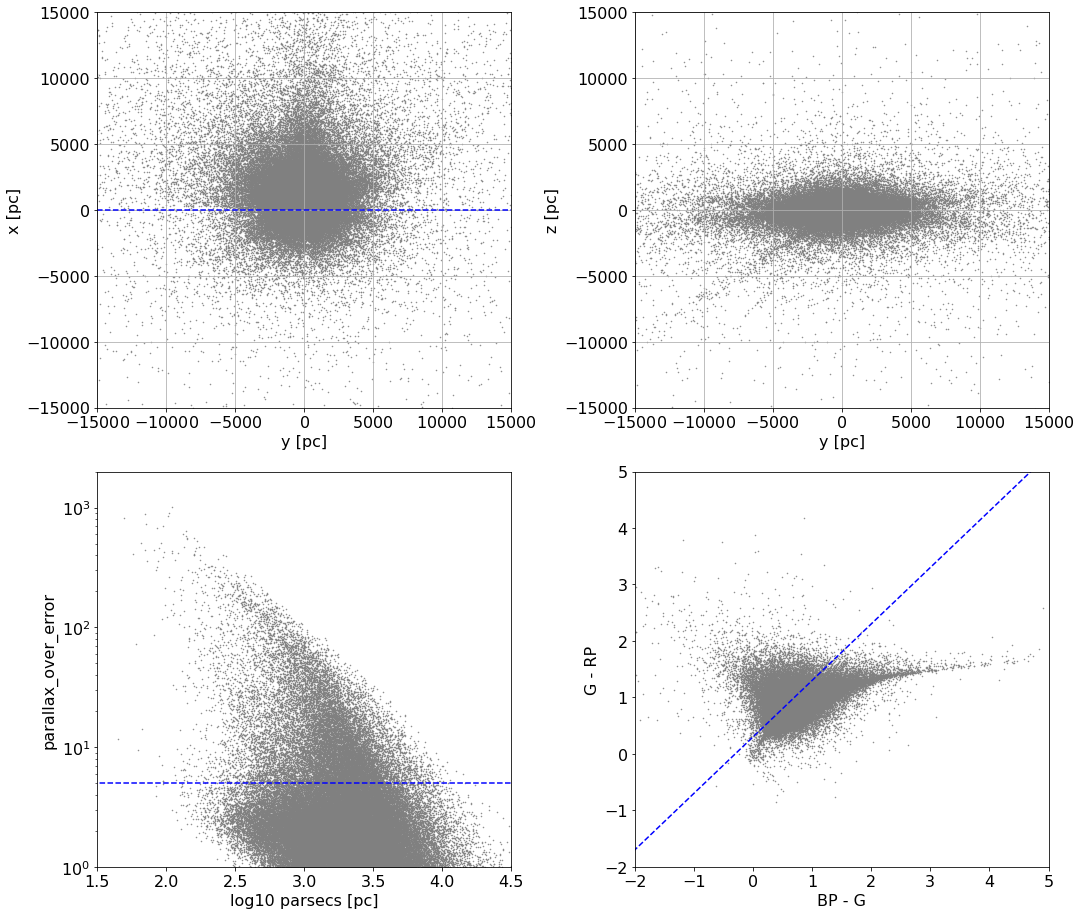

In [46]:
fig = plt.figure(figsize=(15,12.7))

# plot settings
#plt.rc('font', family='serif') 
#plt.rc('font', serif='Times New Roman') 
plt.rcParams.update({'font.size': 16})
#plt.rcParams['mathtext.fontset'] = 'stix'

plt.subplot(221)
plt.axis([-15000,15000,-15000,15000])
#plt.axes().set_aspect('equal')
#plt.axes().set_aspect('equal', 'datalim')
#plt.title(r'Gaia Galactic 3D Coordinates (|z| < 5 kpc)')
plt.xlabel(r'y [pc]')
plt.ylabel(r'x [pc]')
plt.scatter(testdf.gal_y.values,testdf.gal_x.values,marker=".",s=1.0,color='grey')
plt.grid()
plt.ticklabel_format(axis='x',style='sci',useMathText=True)
plt.plot([-15000,15000],[0,0],linestyle='--',color='b')

plt.subplot(222)
plt.axis([-15000,15000,-15000,15000])
#plt.axes().set_aspect('equal')
#plt.axes().set_aspect('equal', 'datalim')
#plt.title(r'Gaia Galactic 3D Coordinates (|z| < 5 kpc)')
plt.xlabel(r'y [pc]')
plt.ylabel(r'z [pc]')
plt.scatter(testdf.gal_y.values,testdf.gal_z.values,marker=".",s=1.0,color='grey')
plt.grid()
plt.ticklabel_format(axis='x',style='sci',useMathText=True)

plt.subplot(223)
plt.axis([1.5,4.5,1,2000])
#plt.axes().set_aspect('equal', 'datalim')
#plt.title(r'Gaia Galactic 3D Coordinates (|z| < 5 kpc)')
plt.xlabel(r'log10 parsecs [pc]')
plt.ylabel(r'parallax_over_error')
plt.scatter(testdf.logparsecs.values,testdf.parallax_over_error.values,marker=".",s=1.0,color='grey')
plt.yscale('log')
plt.plot([1,20000],[5,5],linestyle='--',color='b')
#plt.grid()


plt.subplot(224)
plt.axis([-2,5,-2,5])
#plt.axes().set_aspect('equal', 'datalim')
#plt.title(r'Gaia Galactic 3D Coordinates (|z| < 5 kpc)')
plt.xlabel(r'BP - G')
plt.ylabel(r'G - RP')
plt.scatter(testdf.bp_g.values,testdf.g_rp.values,marker=".",s=1.0,color='grey')
#plt.yscale('log')
plt.plot(xx,yy,linestyle='--',color='b')



plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
fig.savefig("gaia-stats-short.pdf")
fig.savefig("gaia-stats-short.png")
plt.show()

#### Color Selection

In [40]:
%%time
colordf = stardf.filter((F.col('parallax_over_error') > 5.0) & (F.col('g_rp') - F.col('bp_g') > 0.3) \
                        & (F.col('gal_x') < 0.0)).toPandas()

CPU times: user 253 ms, sys: 265 ms, total: 517 ms
Wall time: 2min 2s


In [47]:
len(colordf.index)

1125629

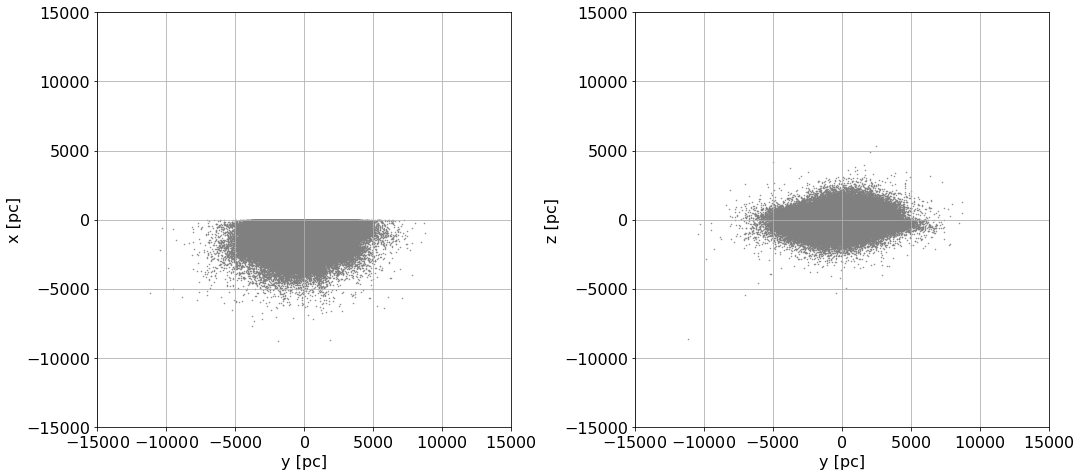

In [42]:
fig = plt.figure(figsize=(15,6.6))

# plot settings
#plt.rc('font', family='serif') 
#plt.rc('font', serif='Times New Roman') 
plt.rcParams.update({'font.size': 16})
#plt.rcParams['mathtext.fontset'] = 'stix'

plt.subplot(121)
plt.axis([-15000,15000,-15000,15000])
#plt.axes().set_aspect('equal')
#plt.axes().set_aspect('equal', 'datalim')
#plt.title(r'Gaia Galactic 3D Coordinates (|z| < 5 kpc)')
plt.xlabel(r'y [pc]')
plt.ylabel(r'x [pc]')
plt.scatter(colordf.gal_y.values,colordf.gal_x.values,marker=".",s=1.0,color='grey')
plt.grid()
plt.ticklabel_format(axis='x',style='sci',useMathText=True)

plt.subplot(122)
plt.axis([-15000,15000,-15000,15000])
#plt.axes().set_aspect('equal')
#plt.axes().set_aspect('equal', 'datalim')
#plt.title(r'Gaia Galactic 3D Coordinates (|z| < 5 kpc)')
plt.xlabel(r'y [pc]')
plt.ylabel(r'z [pc]')
plt.scatter(colordf.gal_y.values,colordf.gal_z.values,marker=".",s=1.0,color='grey')
plt.grid()
plt.ticklabel_format(axis='x',style='sci',useMathText=True)




plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
#fig.savefig("gaia-stats.pdf")
fig.savefig("gaia-color-select.png")
plt.show()

In [43]:
ybins = np.arange(201)*100.0 - 10000.0
xbins = +100.0* np.arange(101) - 10000.0
zbins = np.arange(101)*100.0 - 5000.0

<ipython-input-44-f5cc9545fd0f>:17: RuntimeWarning: divide by zero encountered in log10
  im1 = plt.imshow(np.log10(tmpheat.T), extent=extent, origin='lower')
<ipython-input-44-f5cc9545fd0f>:29: RuntimeWarning: divide by zero encountered in log10
  im2 = plt.imshow(np.log10(tmpheat.T), extent=extent, origin='lower')


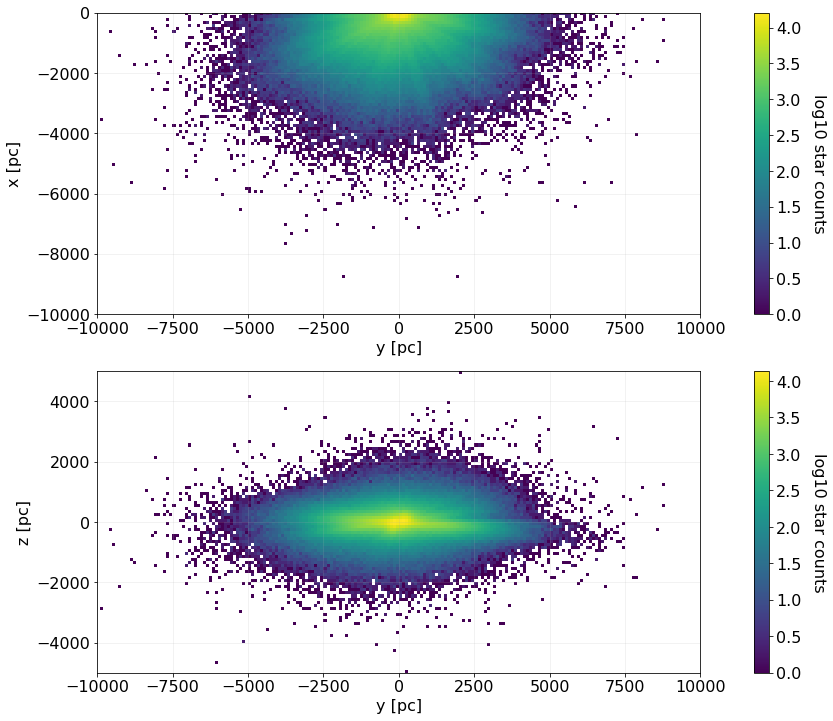

In [44]:
from matplotlib import colors
fig = plt.figure(figsize=(15,10))

# plot settings
#plt.rc('font', family='serif') 
#plt.rc('font', serif='Times New Roman') 
plt.rcParams.update({'font.size': 16})
#plt.rcParams['mathtext.fontset'] = 'stix'

plt.subplot(211)
tmpheat, xedges, yedges = np.histogram2d(colordf.gal_y.values,colordf.gal_x.values,bins=[ybins,xbins])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
#plt.clf()
plt.xlabel(r'y [pc]')
plt.ylabel(r'x [pc]')
plt.grid(alpha=0.2)
im1 = plt.imshow(np.log10(tmpheat.T), extent=extent, origin='lower')
cbar1 = plt.colorbar(im1)
cbar1.set_label('log10 star counts',labelpad=+25,rotation=270)


plt.subplot(212)
tmpheat, xedges, yedges = np.histogram2d(colordf.gal_y.values,colordf.gal_z.values,bins=[ybins,zbins])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
#plt.clf()
plt.grid(alpha=0.2)
plt.xlabel(r'y [pc]')
plt.ylabel(r'z [pc]')
im2 = plt.imshow(np.log10(tmpheat.T), extent=extent, origin='lower')
cbar2 = plt.colorbar(im2)
cbar2.set_label('log10 star counts',labelpad=+25,rotation=270)


plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
#fig.savefig("gaia-stats.pdf")
fig.savefig("gaia-color-heatmap.png")
plt.show()

